In [36]:
#import libraries....

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import Normalizer,MinMaxScaler,StandardScaler

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier


import datetime

import warnings
warnings.filterwarnings("ignore")

<b> We have tried many models but we have not got better results. So here, We are going to try another approach for this problem. 
    
    
* model 1: First we consider score 5 as one class(1) and all other scores as other class(0). And we perform binary classification on this. If we get output 1 then class label is directly 5. Otherwise we model another algorithm for multi class classification among class 1,2,3,4. Since imbalance is not much in this case we can expect better results. 

In [2]:
#load the data with all created features
data = pd.read_csv("data_with_advanced_features.csv")
data.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
#label encoding of seller_id
label = LabelEncoder()
seller = label.fit_transform(data.seller_id)
data["seller_id"] = seller


#label encoding of product id
label = LabelEncoder()
product = label.fit_transform(data.product_id)
data["product_id"] = product


In [4]:
#creating class labels
binary = []
for i in range(len(data)):
    if data.review_score[i]==5:
        binary.append(1)
    else:
        binary.append(0)
        
data["binary_target"] = binary

In [5]:
#target variable is review_score
Y = data["binary_target"]
X = data

<b> Train test split

In [8]:
#train test split with test size 25% and 75% of data as train
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,stratify=Y,random_state=10)

In [9]:
print("Dimensions of the splitted data :")
print("Train: ",x_train.shape,y_train.shape)
print("Test: ",x_test.shape,y_test.shape)

Dimensions of the splitted data :
Train:  (84828, 72) (84828,)
Test:  (28277, 72) (28277,)


In [11]:
#check the distribution of each class in train,test as well as original data
print("% Distribution of class labels in the total data :")
print(round(data["binary_target"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the train data :")
print(round(x_train["binary_target"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the test data :")
print(round(x_test["binary_target"].value_counts(normalize=True)*100,2))
print("*"*50)


% Distribution of class labels in the total data :
1    57.15
0    42.85
Name: binary_target, dtype: float64
**************************************************
% Distribution of class labels in the train data :
1    57.15
0    42.85
Name: binary_target, dtype: float64
**************************************************
% Distribution of class labels in the test data :
1    57.15
0    42.85
Name: binary_target, dtype: float64
**************************************************


### Featurization

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
#payment_type 
vec = CountVectorizer()

vec.fit(x_train["payment_type"].values)

x_tr_pay_type = vec.transform(x_train.payment_type.values)
x_te_pay_type = vec.transform(x_test.payment_type.values)

print(x_tr_pay_type.shape)
print(x_te_pay_type.shape)


(84828, 4)
(28277, 4)


In [ ]:
#order_item_id 

In [15]:
x_train.order_item_id = x_train.order_item_id.astype(str)
x_test.order_item_id = x_test.order_item_id.astype(str)

In [16]:
#order_item_id 
vec = CountVectorizer(vocabulary=range(1,22))

vec.fit(x_train["order_item_id"])

x_tr_id = vec.transform(x_train.order_item_id)
x_te_id = vec.transform(x_test.order_item_id)

print(x_tr_id.shape)

print(x_te_id.shape)


(84828, 21)
(28277, 21)


In [17]:
#product_category_name
vec = CountVectorizer()

vec.fit(x_train["product_category_name"].values)

x_tr_cat = vec.transform(x_train.product_category_name.values)
#x_cv_cat = vec.transform(x_cv.product_category_name.values).toarray()
x_te_cat = vec.transform(x_test.product_category_name.values)

print(x_tr_cat.shape)
#print(x_cv_cat.shape)
print(x_te_cat.shape)


(84828, 73)
(28277, 73)


<b> Binary features

In [18]:
x_tr_same_state = x_train.same_state.values.reshape(-1,1)
x_te_same_state = x_test.same_state.values.reshape(-1,1)

x_tr_same_city = x_train.same_city.values.reshape(-1,1)
x_te_same_city = x_test.same_city.values.reshape(-1,1)

x_tr_late_shipping = x_train.late_shipping.values.reshape(-1,1)
x_te_late_shipping = x_test.late_shipping.values.reshape(-1,1)

x_tr_high_freight = x_train.high_freight.values.reshape(-1,1)
x_te_high_freight = x_test.high_freight.values.reshape(-1,1)

<b> Numerical features

In [19]:
def scaling(train_data,test_data):
    """This function will standardize the numerical data"""
    norm = StandardScaler()

    norm.fit(train_data.values)

    x_tr_num = norm.transform(train_data.values)
    x_te_num = norm.transform(test_data.values)


    return x_tr_num,x_te_num

In [20]:
#data to be standardized
tr = x_train[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]

te = x_test[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]


In [21]:
#standardizing
x_tr_num,x_te_num = scaling(tr,te)

In [22]:
from scipy.sparse import hstack
#horizontal stacking of all the features
train = hstack((x_tr_pay_type,x_tr_id,x_tr_cat,x_tr_num,x_tr_same_state,
                   x_tr_same_city,x_tr_late_shipping,x_tr_high_freight)).toarray()

test = hstack((x_te_pay_type,x_te_id,x_te_cat,x_te_num,x_te_same_state,
                 x_te_same_city,x_te_late_shipping,x_te_high_freight)).toarray()

In [23]:
#shape of final train and test data
print("Shape of train data : ",train.shape)
print("Shape of test data : ",test.shape)

Shape of train data :  (84828, 142)
Shape of test data :  (28277, 142)


In [25]:
#reset the index of target variable
y_trains = y_train.reset_index()
y_train = y_trains["binary_target"]

y_tests = y_test.reset_index()
y_test = y_tests["binary_target"]

## ML models

In [26]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """This function will plot confusion matrix, precision matrix and recall matrix"""
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [28]:
def kfold(k,model,trains,y_trains):
    """This function will do stratified k-fold cross_validation"""
    kf = StratifiedKFold(n_splits=k)
    
    cv_f1_score = []
    for tr_ind,cv_ind in kf.split(trains,y_trains):
            
        x_tr,x_cv,y_tr,y_cv = trains[tr_ind],trains[cv_ind],y_trains[tr_ind],y_trains[cv_ind]
        
        model.fit(x_tr,y_tr)
        pred_cv = model.predict(x_cv)    
        cv_f1_score.append((f1_score(y_cv,pred_cv,average="macro",labels=[0,1])))
    
    return np.mean(cv_f1_score)               

### Logistic Regression

Macro F1 score at C=1e-05 is 0.6063750815874365 
Macro F1 score at C=0.0001 is 0.6095742704086244 
Macro F1 score at C=0.001 is 0.610961119057039 
Macro F1 score at C=0.01 is 0.6129262895423754 
Macro F1 score at C=0.1 is 0.6128481022485971 
Macro F1 score at C=1 is 0.6128756224346488 
Macro F1 score at C=10 is 0.6126459838606673 
**************************************************


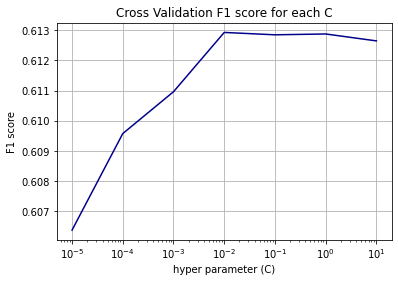

**************************************************
Train F1 score at 0.01 is :0.6143489348445506
**************************************************
test F1 score at 0.01 is :0.6085867692979023
-------------------- Confusion matrix --------------------


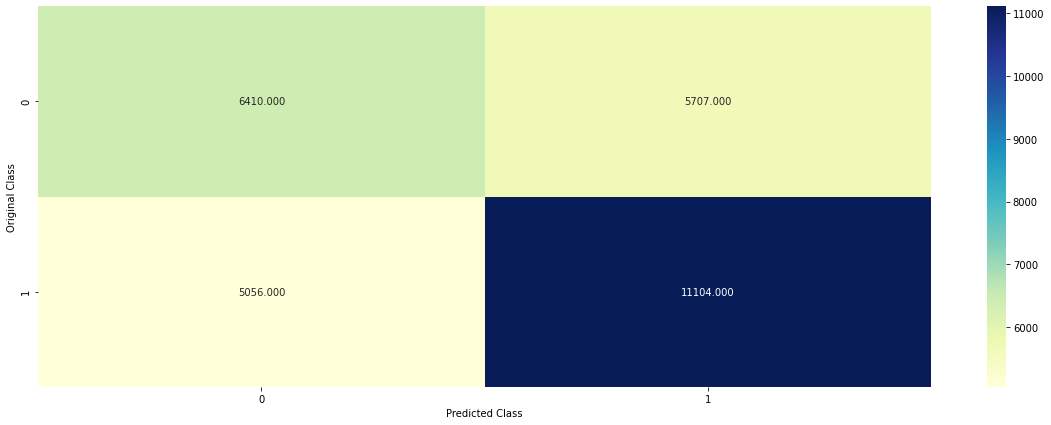

-------------------- Precision matrix (Columm Sum=1) --------------------


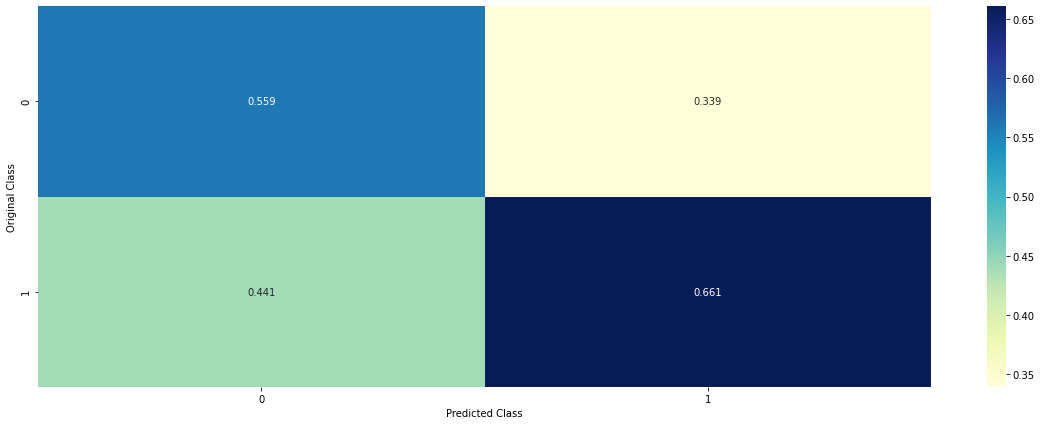

-------------------- Recall matrix (Row sum=1) --------------------


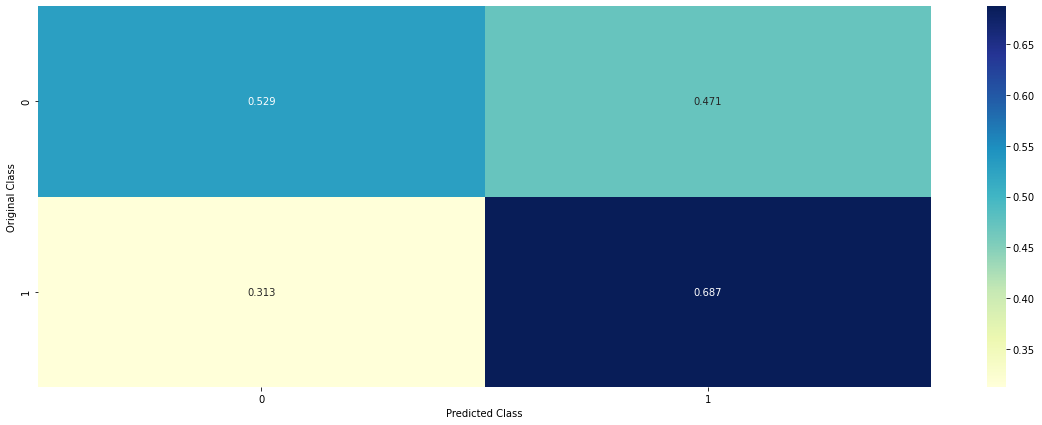

In [30]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### SVM

Macro F1 score at alpha=1e-05 is 0.5702238743215692 
Macro F1 score at alpha=0.0001 is 0.5602507369613238 
Macro F1 score at alpha=0.001 is 0.5762106211443311 
Macro F1 score at alpha=0.01 is 0.5795566313818572 
Macro F1 score at alpha=0.1 is 0.5565829799301854 
Macro F1 score at alpha=1 is 0.3913117199913388 
Macro F1 score at alpha=10 is 0.3382896602036526 
**************************************************


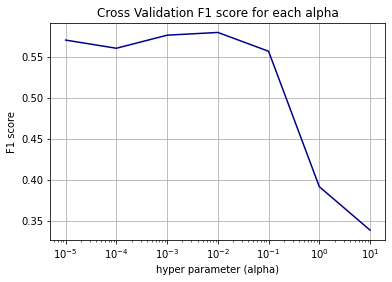

**************************************************
Train F1 score at 0.01 is :0.363654776640036
**************************************************
test F1 score at 0.01 is :0.36375161899674946
-------------------- Confusion matrix --------------------


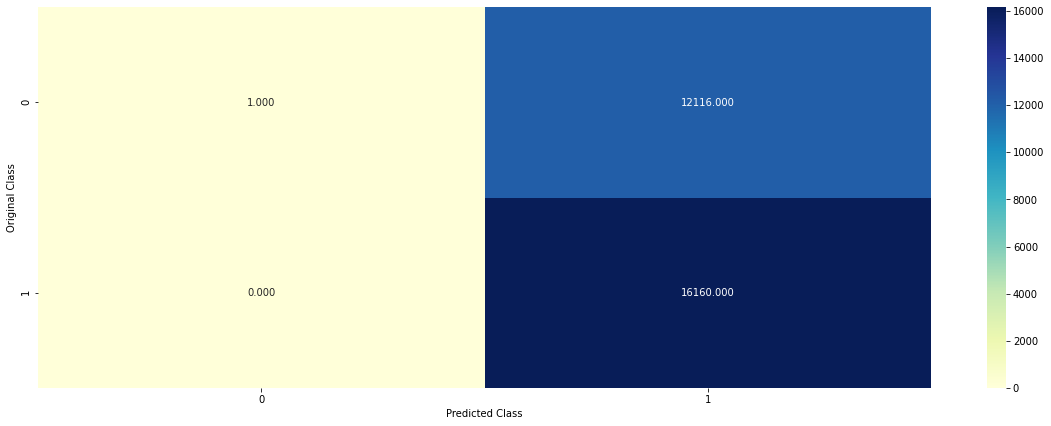

-------------------- Precision matrix (Columm Sum=1) --------------------


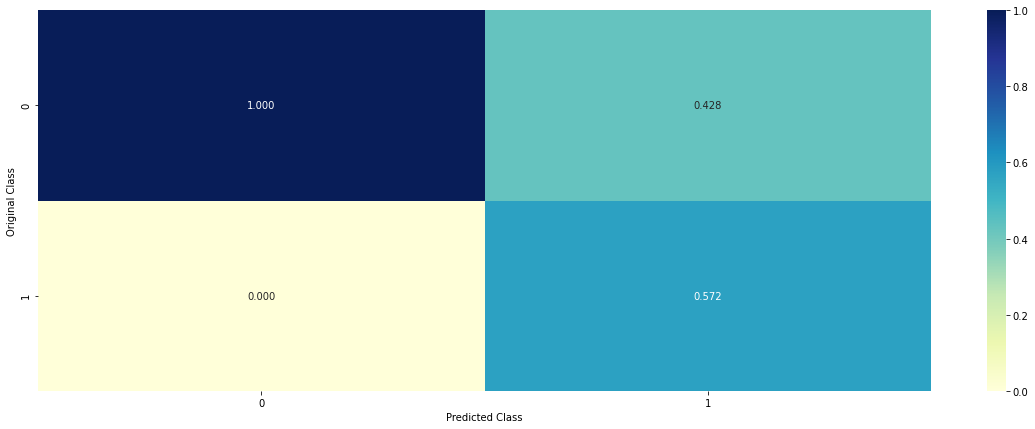

-------------------- Recall matrix (Row sum=1) --------------------


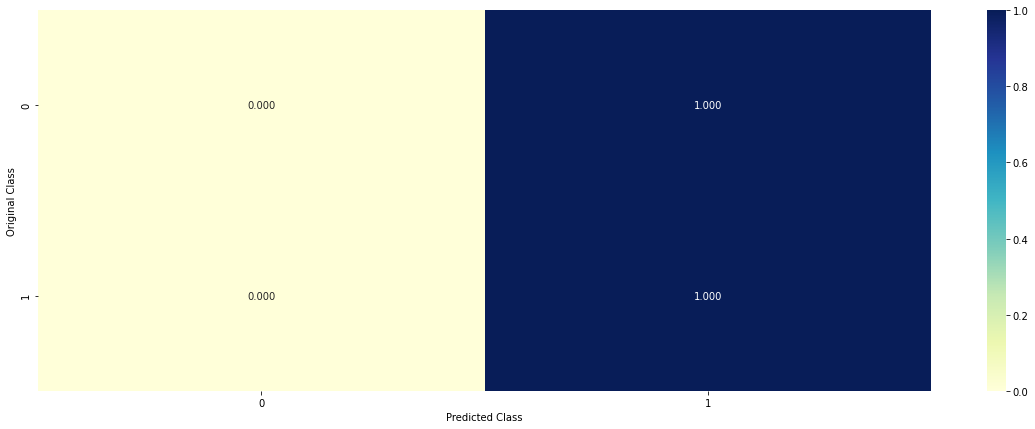

In [35]:
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in alpha:
    model = None
    model = SGDClassifier(alpha=i,loss="hinge")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at alpha={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(alpha,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("hyper parameter (alpha)")
plt.ylabel("F1 score")
plt.show()

best_param = alpha[np.argmax(f1_scores)]

model = None
model = SGDClassifier(alpha=i,loss="hinge")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

<b> This is worst model. It only classified one 0 class point correctly

### KNN

Macro F1 score at n=3 is 0.608388170591514 
Macro F1 score at n=5 is 0.6027820387309053 
Macro F1 score at n=7 is 0.5996393571872104 
Macro F1 score at n=9 is 0.5957337076844775 
Macro F1 score at n=11 is 0.5935967720861097 
Macro F1 score at n=13 is 0.5935895137678464 
**************************************************


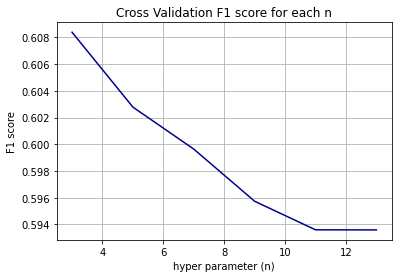

**************************************************
Train F1 score at 3 is :0.8161479646108369
**************************************************
test F1 score at 3 is :0.6114315717337961
-------------------- Confusion matrix --------------------


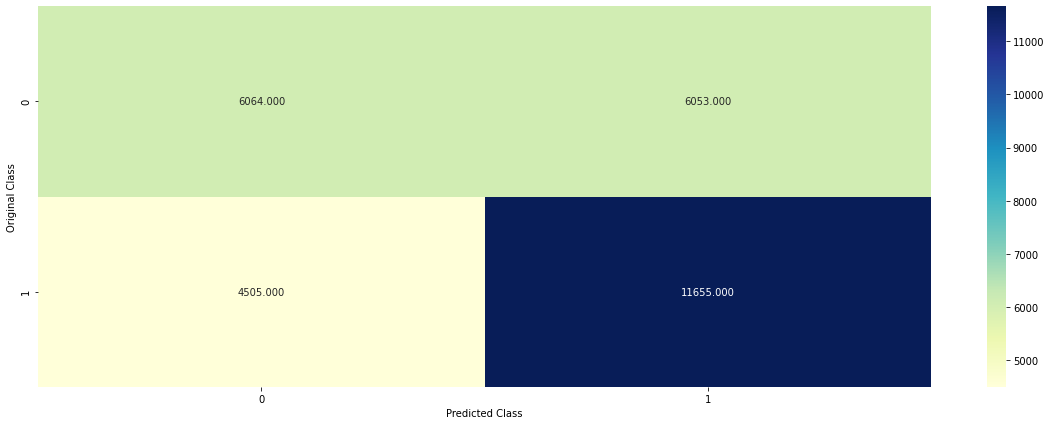

-------------------- Precision matrix (Columm Sum=1) --------------------


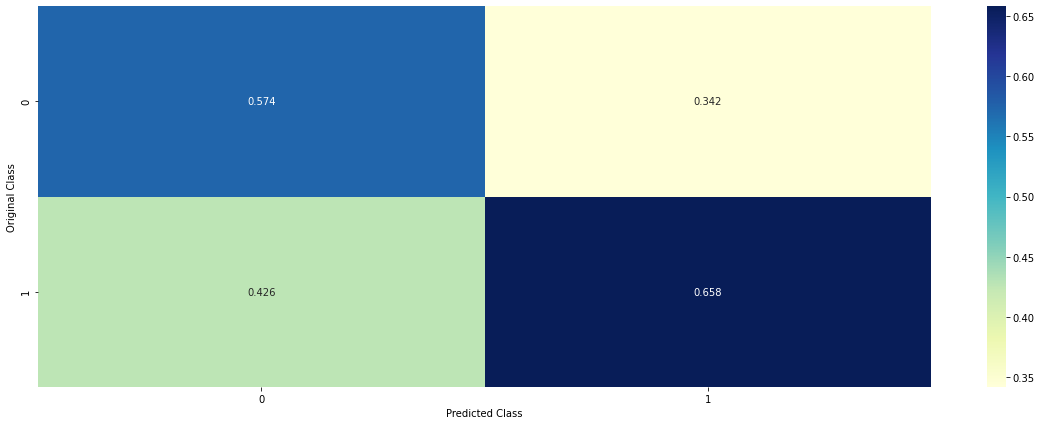

-------------------- Recall matrix (Row sum=1) --------------------


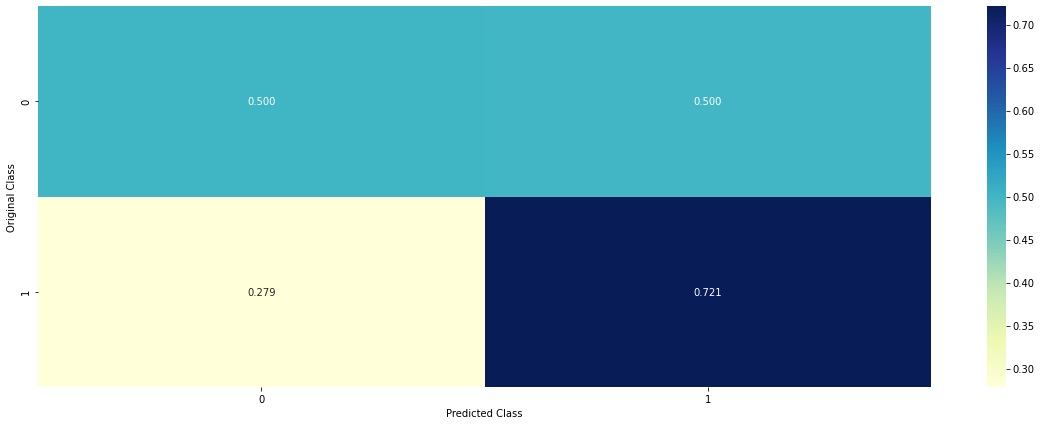

In [38]:
n=[3,5,7,9,11,13]

f1_scores = []
for i in n:
    model = None
    model = KNeighborsClassifier(n_neighbors=i)
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n")
plt.xlabel("hyper parameter (n)")
plt.ylabel("F1 score")
plt.show()

best_param = n[np.argmax(f1_scores)]

model = None
model = KNeighborsClassifier(n_neighbors=best_param)
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### Decision Tree

Macro F1 score at n=2 is 0.5836980311399766 
Macro F1 score at n=5 is 0.6111800756197329 
Macro F1 score at n=6 is 0.6121613080627779 
Macro F1 score at n=8 is 0.6130246368069396 
Macro F1 score at n=10 is 0.6171557777466239 
Macro F1 score at n=12 is 0.6192233051064144 
Macro F1 score at n=15 is 0.6234214172228818 
**************************************************


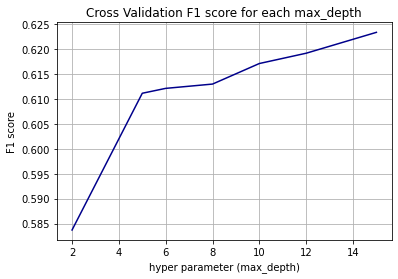

**************************************************
Train F1 score at 15 is :0.7252478785857026
**************************************************
test F1 score at 15 is :0.6208240044481035
-------------------- Confusion matrix --------------------


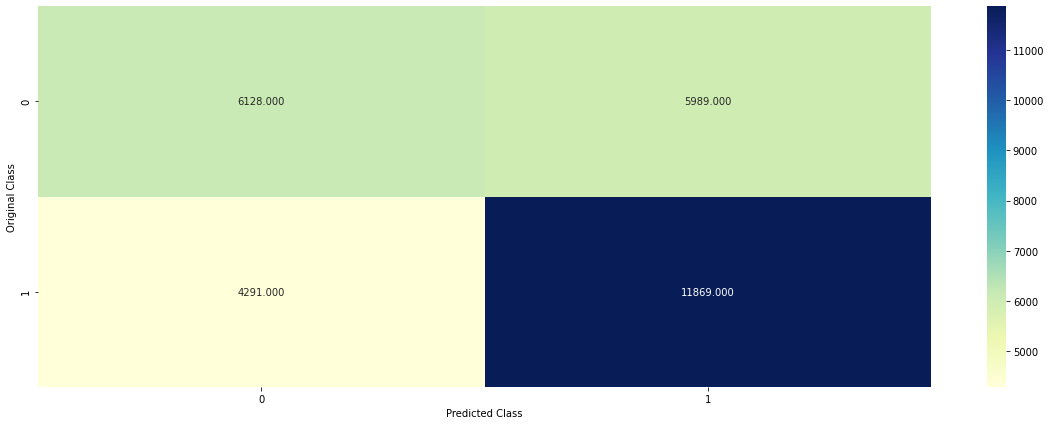

-------------------- Precision matrix (Columm Sum=1) --------------------


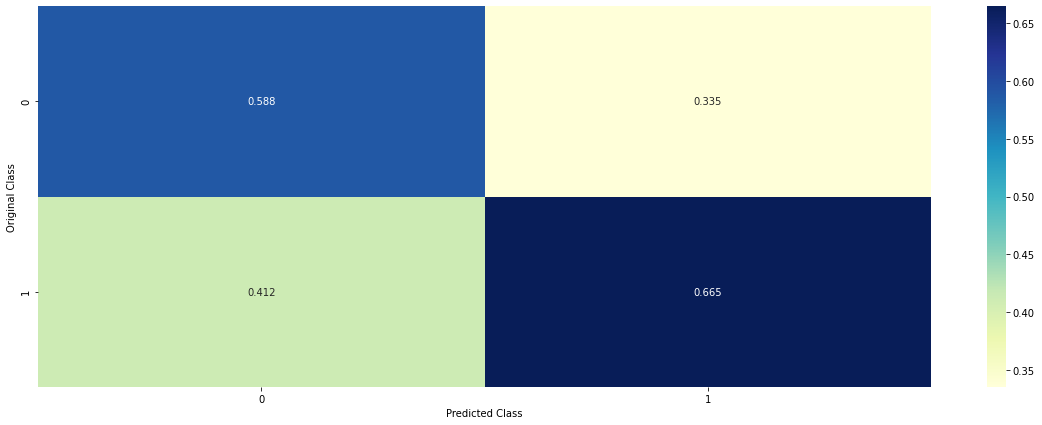

-------------------- Recall matrix (Row sum=1) --------------------


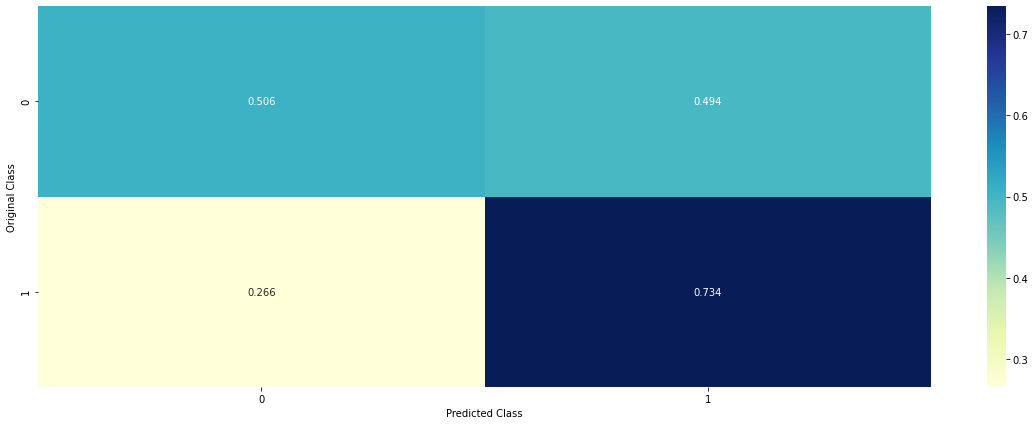

In [39]:
max_depth=[2,5,6,8,10,12,15]

f1_scores = []
for i in max_depth:
    model = None
    model = DecisionTreeClassifier(max_depth=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(max_depth,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each max_depth")
plt.xlabel("hyper parameter (max_depth)")
plt.ylabel("F1 score")
plt.show()

best_param = max_depth[np.argmax(f1_scores)]

model = None
model = DecisionTreeClassifier(max_depth=best_param,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### Random Forest

Macro F1 score at n=10 is 0.637300491316321 
Macro F1 score at n=20 is 0.6559353010925276 
Macro F1 score at n=50 is 0.6712300680658213 
Macro F1 score at n=100 is 0.6720554970099754 
Macro F1 score at n=150 is 0.6729189981028625 
Macro F1 score at n=200 is 0.673906114181481 
Macro F1 score at n=300 is 0.6748127298166114 
Macro F1 score at n=500 is 0.6749546868247867 
**************************************************


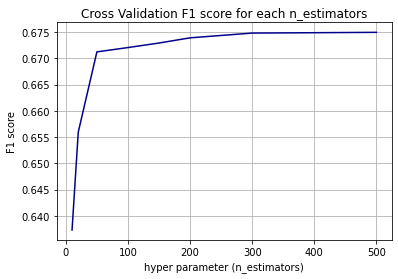

**************************************************
Train F1 score at 500 is :0.9989050920209032
**************************************************
test F1 score at 500 is :0.6790110979361804
-------------------- Confusion matrix --------------------


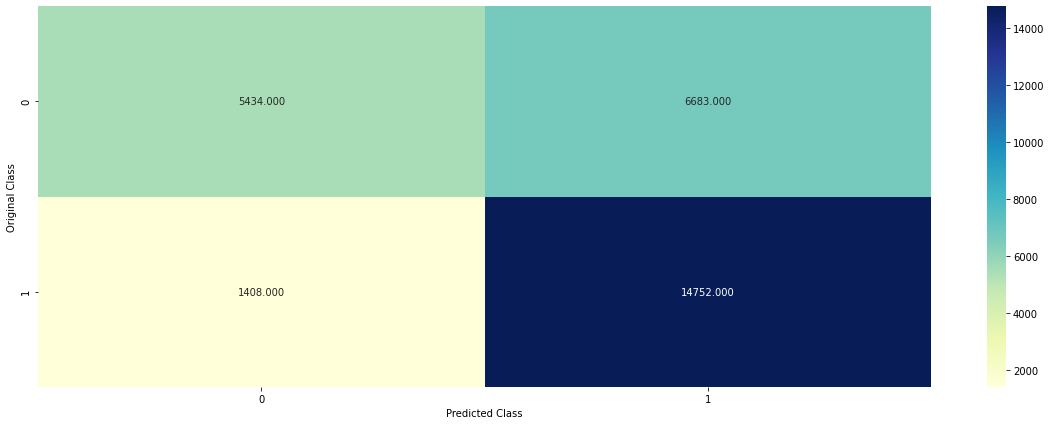

-------------------- Precision matrix (Columm Sum=1) --------------------


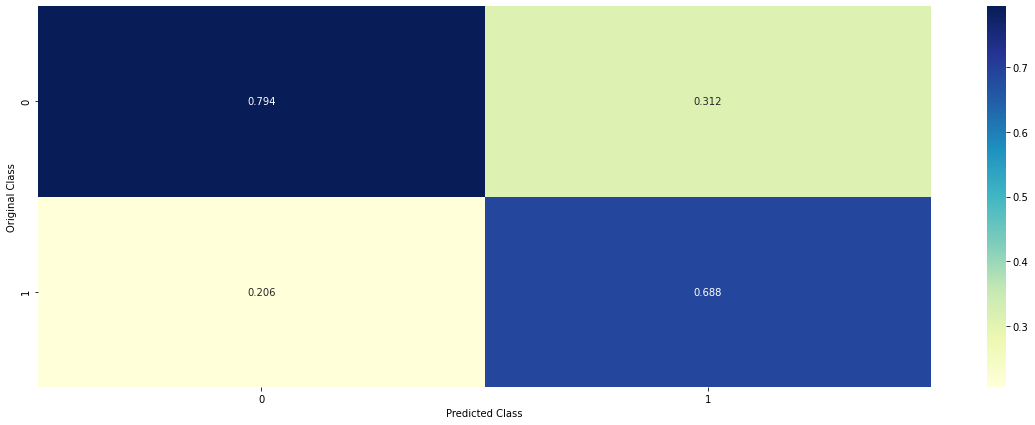

-------------------- Recall matrix (Row sum=1) --------------------


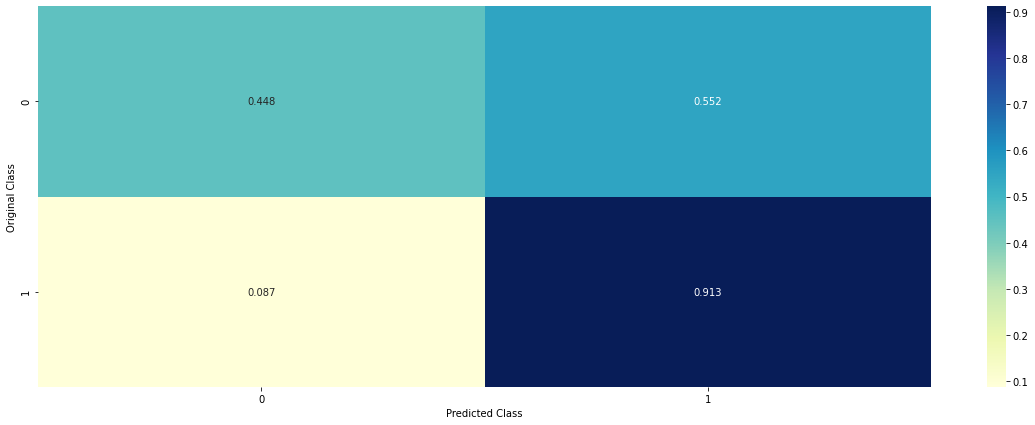

In [40]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param,class_weight="balanced")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

### LGBM

Macro F1 score at n=100 is 0.6240985576664595 
Macro F1 score at n=150 is 0.6258668415333054 
Macro F1 score at n=200 is 0.6251176191825681 
Macro F1 score at n=300 is 0.6245709018718093 
Macro F1 score at n=500 is 0.6268655262237405 
Macro F1 score at n=1000 is 0.6319505828461233 
Macro F1 score at n=2000 is 0.6408117802582668 
**************************************************


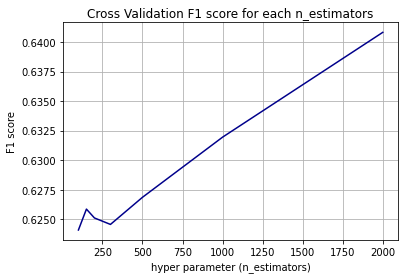

**************************************************
Train F1 score at 2000 is  :0.9254666480999973 
**************************************************
test F1 score at 2000 is :0.6443430798206108 
-------------------- Confusion matrix --------------------


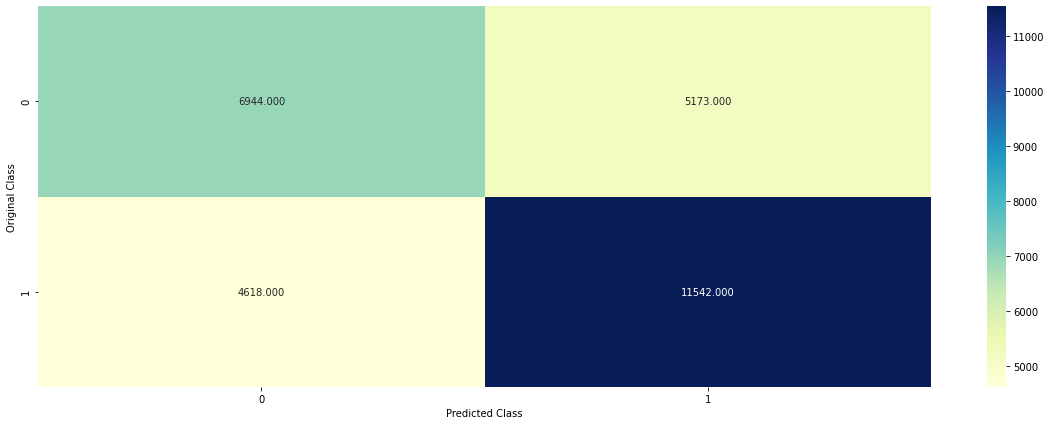

-------------------- Precision matrix (Columm Sum=1) --------------------


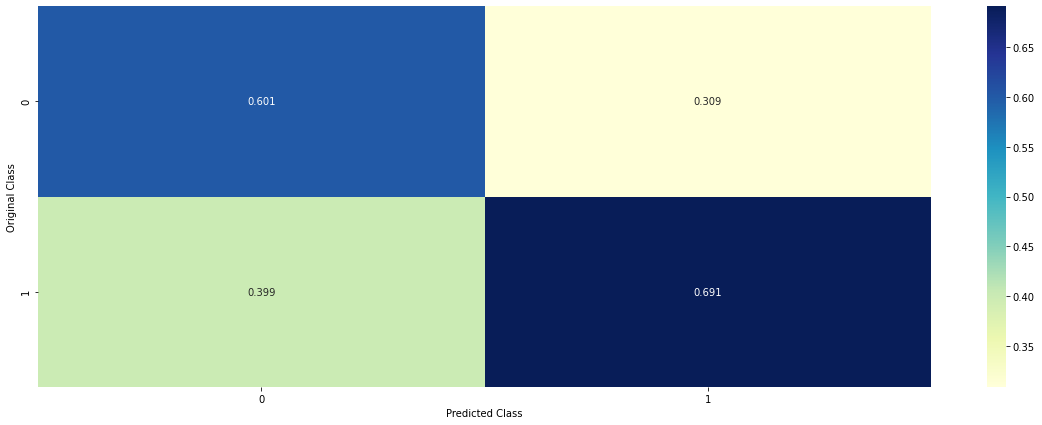

-------------------- Recall matrix (Row sum=1) --------------------


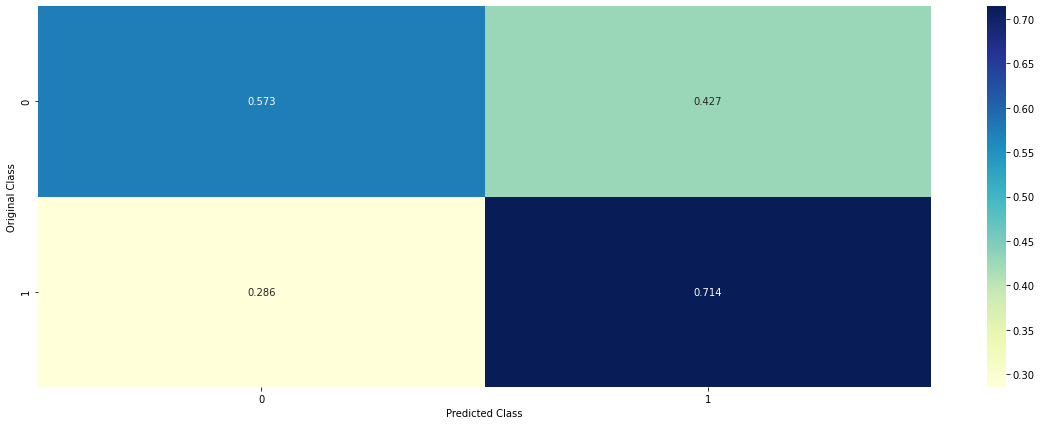

In [41]:
n_estimators=[100,150,200,300,500,1000,2000]

f1_scores = []
for i in n_estimators:
    model = None
    model = lgb.LGBMClassifier(n_estimators=i,class_weight="balanced",boosting_type ="goss")
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_n = n_estimators[np.argmax(f1_scores)]


model = None
model = lgb.LGBMClassifier(n_estimators=best_n,class_weight='balanced',boosting_type ="goss")
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)


### XGBoost

[12:03:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:13:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

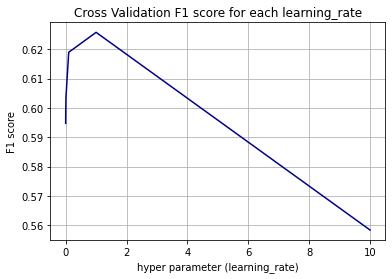

[12:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:15:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 1 is  :0.8070625906785363 
**************************************************
test F1 score at 1 is :0.6287153755871924 
-------------------- Confusion matrix --------------------


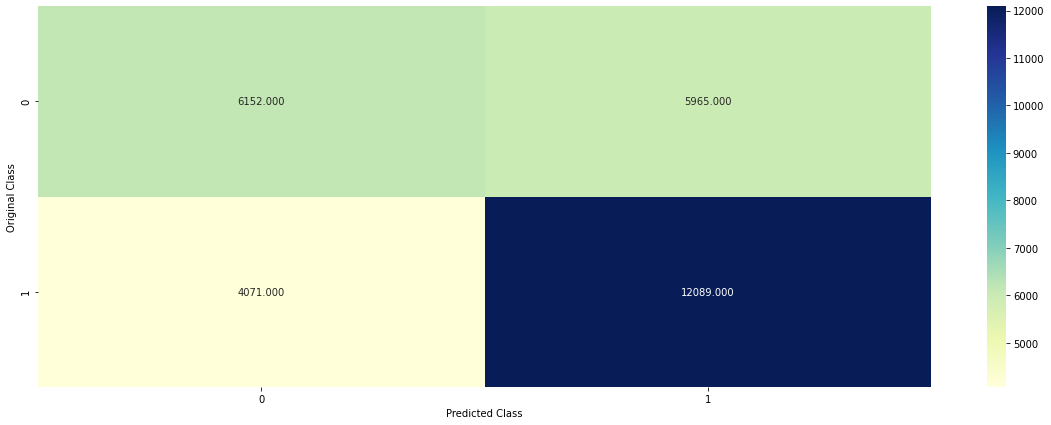

-------------------- Precision matrix (Columm Sum=1) --------------------


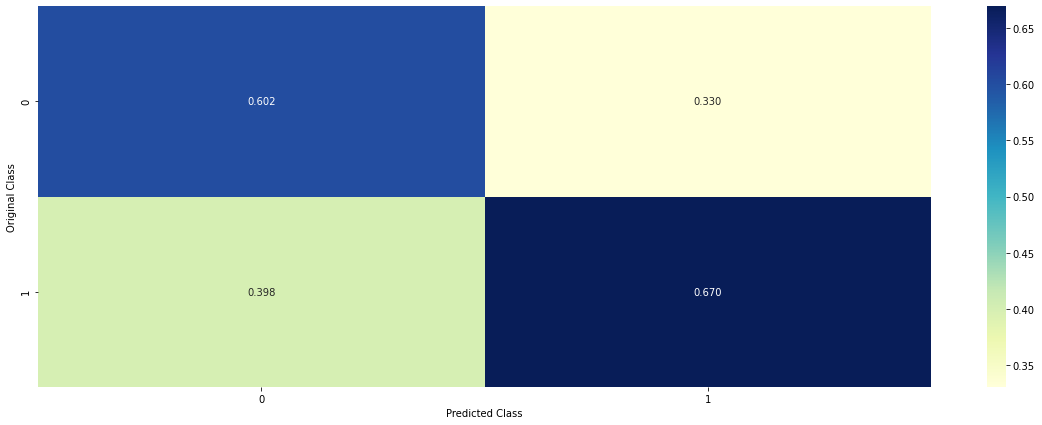

-------------------- Recall matrix (Row sum=1) --------------------


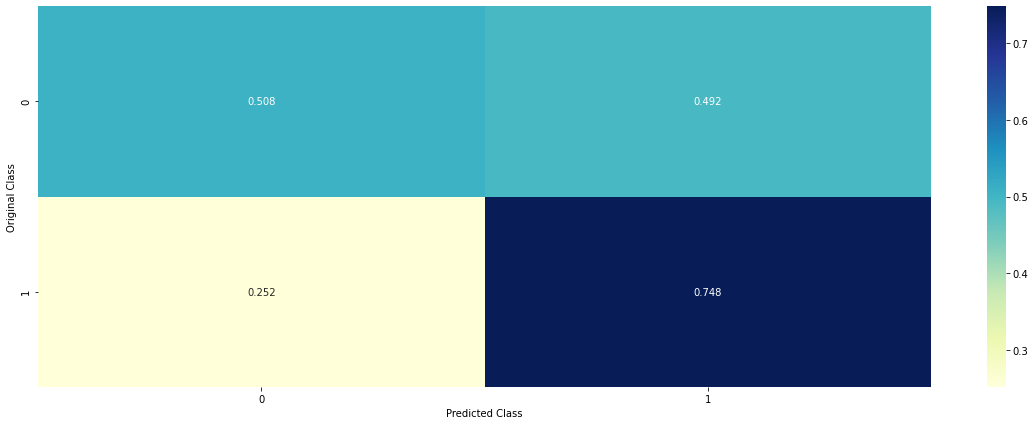

In [42]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBClassifier(learning_rate=i)
    k_fold_score = kfold(5,model,train,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBClassifier(learning_rate=best_n,class_weight='balanced')
model.fit(train,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test)
plot_confusion_matrix(y_test,predicted)

In [ ]:
################################################################################################################################

### With feature selection

In [43]:
#https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

from sklearn.feature_selection import SelectKBest,f_classif

features = SelectKBest(f_classif,k=60)
train_features = features.fit_transform(train,y_train)
test_features = features.transform(test)

## Logistic regression

Macro F1 score at C=1e-05 is 0.6065611994907232 
Macro F1 score at C=0.0001 is 0.6091454282792256 
Macro F1 score at C=0.001 is 0.610747852458414 
Macro F1 score at C=0.01 is 0.6127158140709913 
Macro F1 score at C=0.1 is 0.6127603048005288 
Macro F1 score at C=1 is 0.6127910668197848 
Macro F1 score at C=10 is 0.6124107526363478 
**************************************************


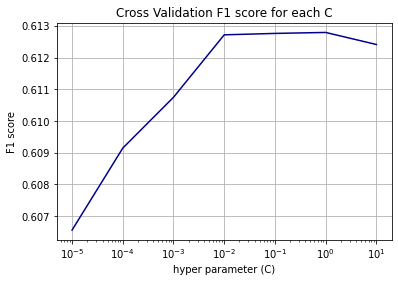

**************************************************
Train F1 score at 1 is :0.6135130483468267
**************************************************
test F1 score at 1 is :0.6046335358696402
-------------------- Confusion matrix --------------------


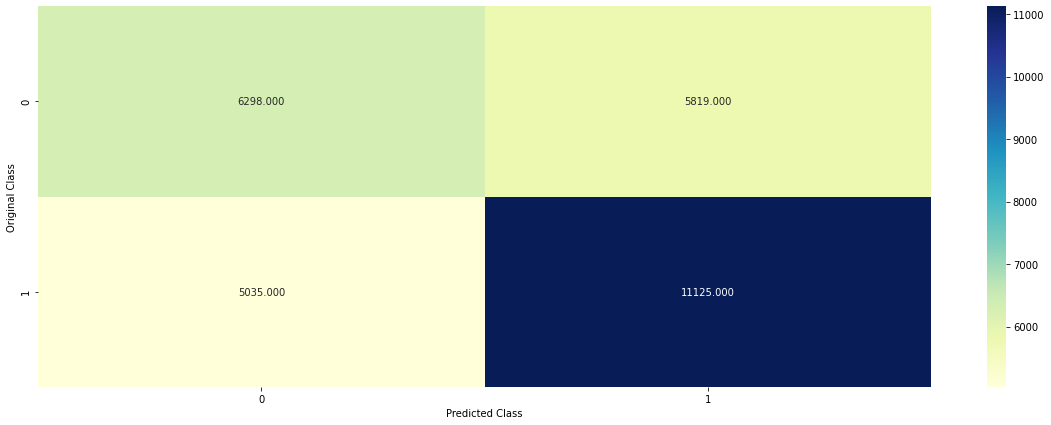

-------------------- Precision matrix (Columm Sum=1) --------------------


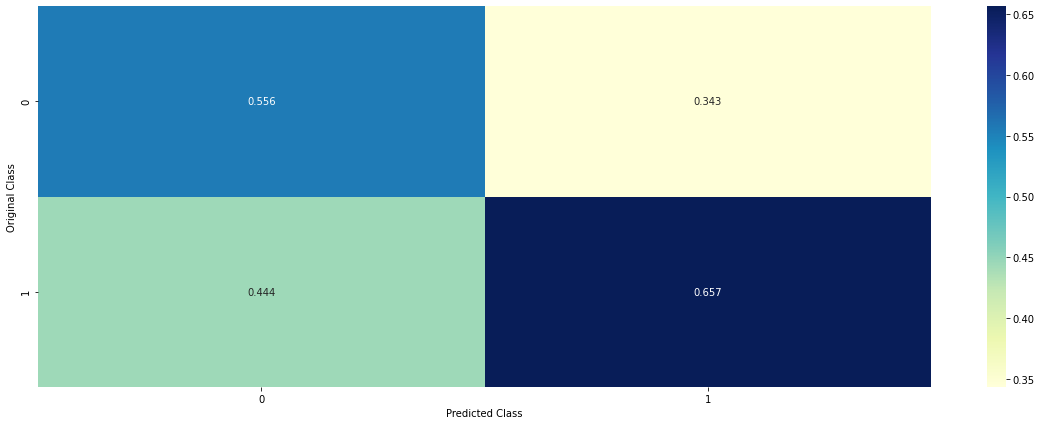

-------------------- Recall matrix (Row sum=1) --------------------


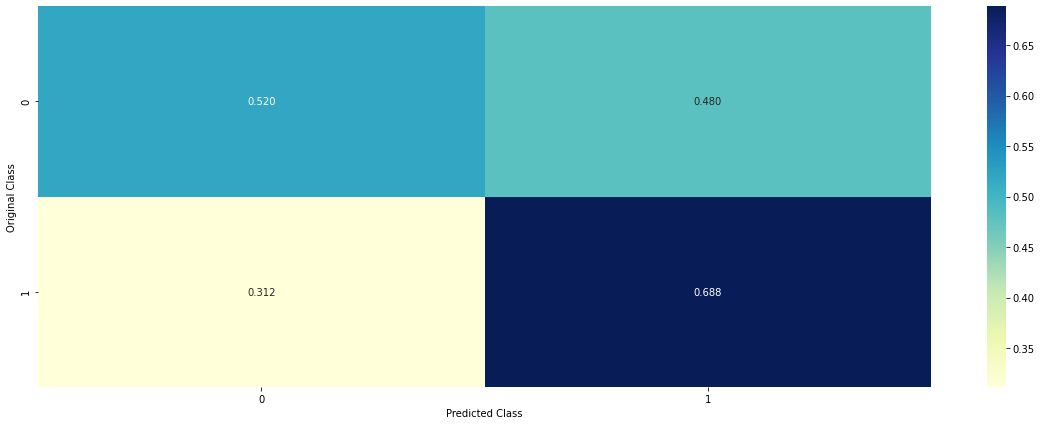

In [44]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i,class_weight="balanced")
    k_fold_score = kfold(5,model,train_features,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i,class_weight="balanced")
model.fit(train_features,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train_features),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### Random Forest

Macro F1 score at n=10 is 0.6366522365073122 
Macro F1 score at n=20 is 0.6599070522381021 
Macro F1 score at n=50 is 0.6697476857067847 
Macro F1 score at n=100 is 0.6728234298199407 
Macro F1 score at n=150 is 0.6738489776029204 
Macro F1 score at n=200 is 0.6749775097475746 
Macro F1 score at n=300 is 0.6752880332920729 
Macro F1 score at n=500 is 0.6748973799237735 
**************************************************


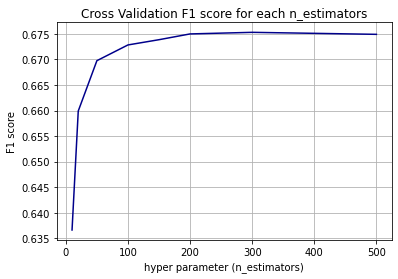

**************************************************
Train F1 score at 300 is :0.9989048288775585
**************************************************
test F1 score at 300 is :0.6832635427909786
-------------------- Confusion matrix --------------------


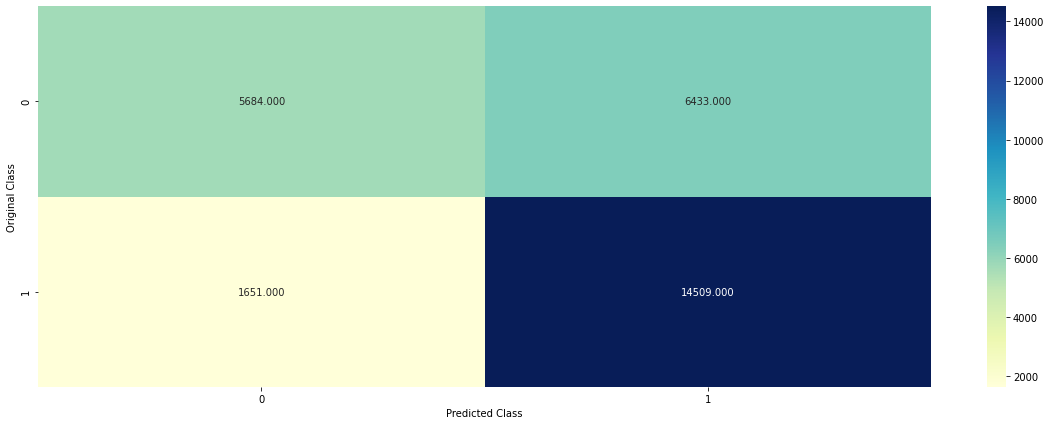

-------------------- Precision matrix (Columm Sum=1) --------------------


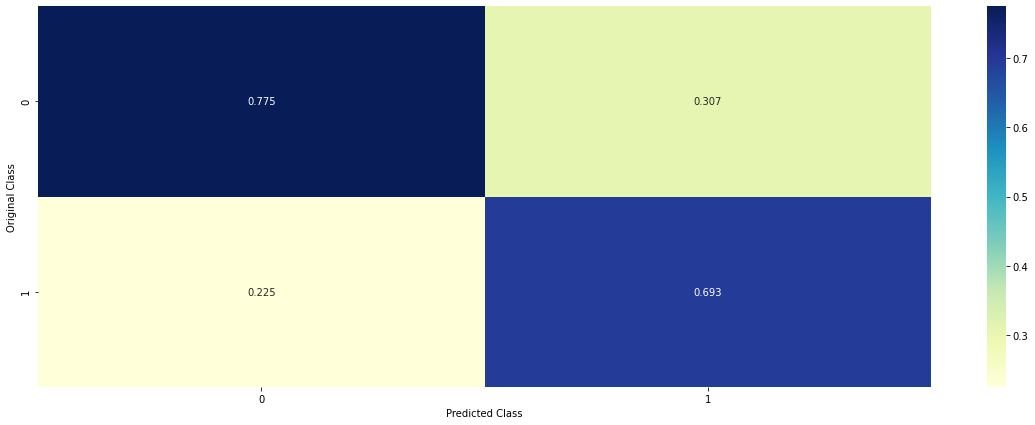

-------------------- Recall matrix (Row sum=1) --------------------


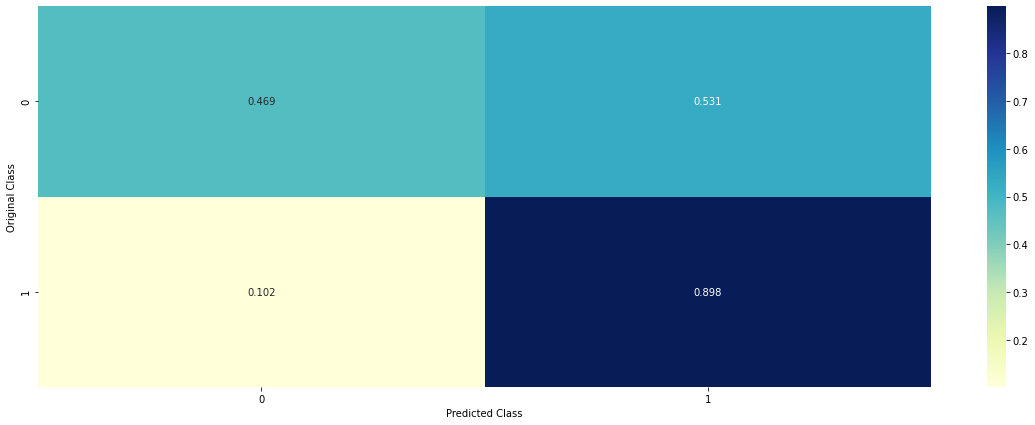

In [45]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i)
    k_fold_score = kfold(5,model,train_features,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param)
model.fit(train_features,y_train)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_train,model.predict(train_features),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### LGBM

Macro F1 score at n=100 is 0.6239668964732157 
Macro F1 score at n=150 is 0.6241565396488904 
Macro F1 score at n=200 is 0.6234944101793376 
Macro F1 score at n=300 is 0.6236670083081521 
Macro F1 score at n=500 is 0.6261721192404782 
Macro F1 score at n=1000 is 0.6291413179840365 
Macro F1 score at n=2000 is 0.6372546572483596 
**************************************************


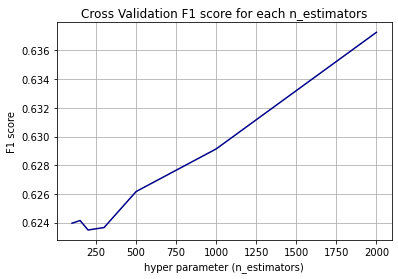

**************************************************
Train F1 score at 2000 is  :0.9595136648161593 
**************************************************
test F1 score at 2000 is :0.6722141594514277 
-------------------- Confusion matrix --------------------


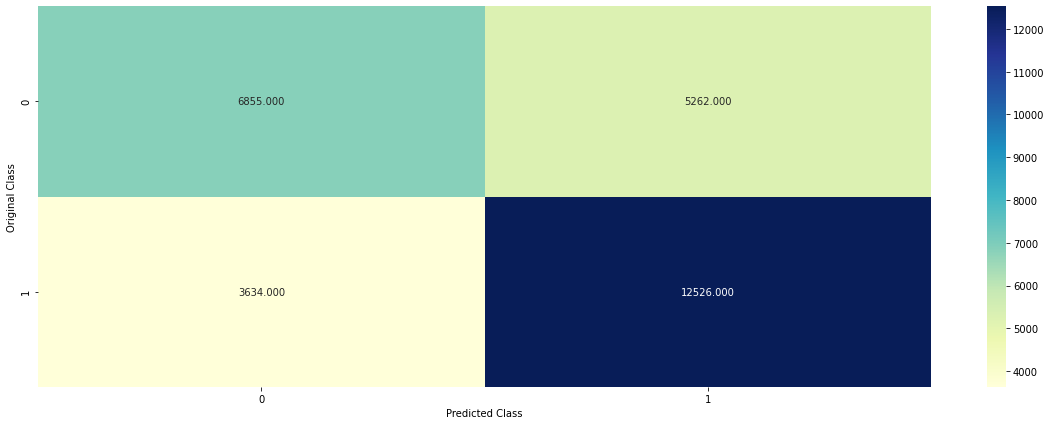

-------------------- Precision matrix (Columm Sum=1) --------------------


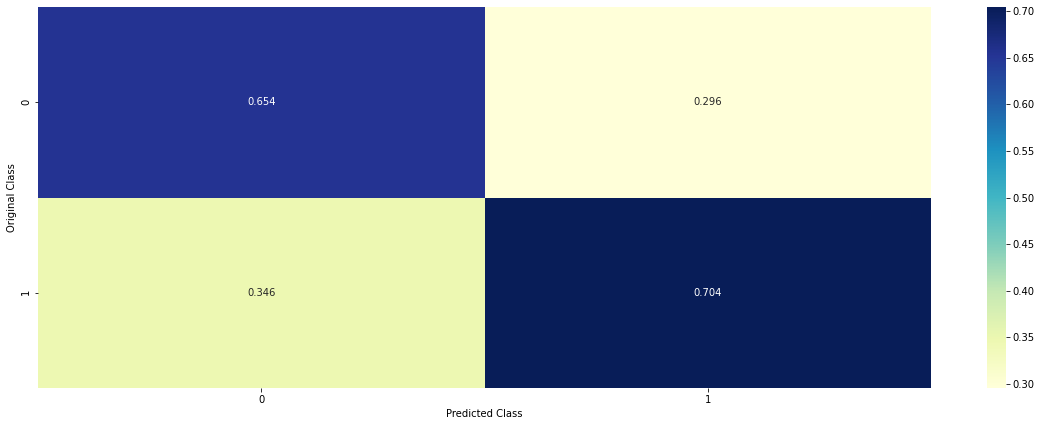

-------------------- Recall matrix (Row sum=1) --------------------


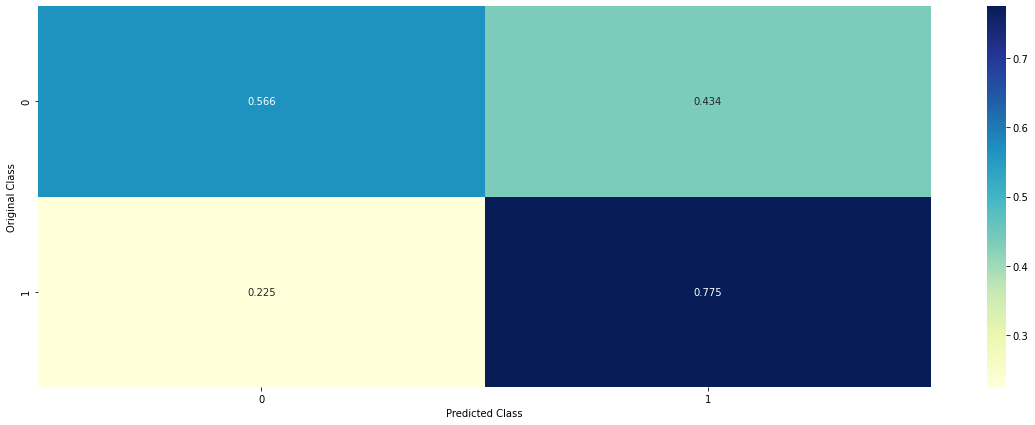

In [46]:
n_estimators=[100,150,200,300,500,1000,2000]

f1_scores = []
for i in n_estimators:
    model = None
    model = lgb.LGBMClassifier(n_estimators=i,class_weight="balanced",boosting_type ="goss")
    k_fold_score = kfold(5,model,train_features,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_n = n_estimators[np.argmax(f1_scores)]


model = None
model = lgb.LGBMClassifier(n_estimators=best_n,class_weight='balanced')
model.fit(train_features,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train_features),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)


### XGB

[13:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:31:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:32:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

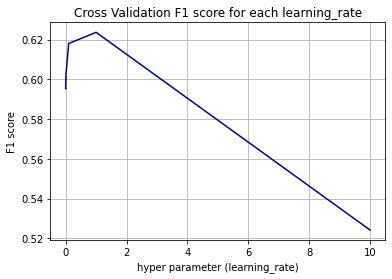

[13:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 1 is  :0.8039011036870076 
**************************************************
test F1 score at 1 is :0.6261561809519818 
-------------------- Confusion matrix --------------------


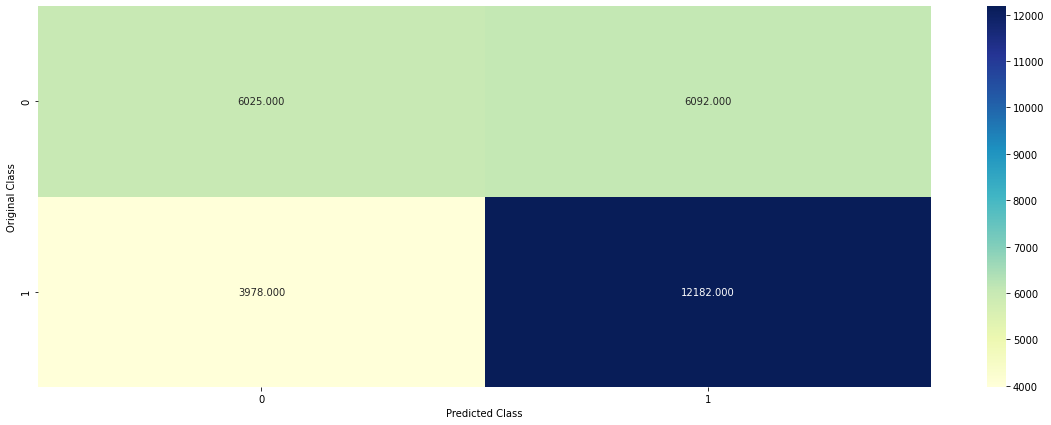

-------------------- Precision matrix (Columm Sum=1) --------------------


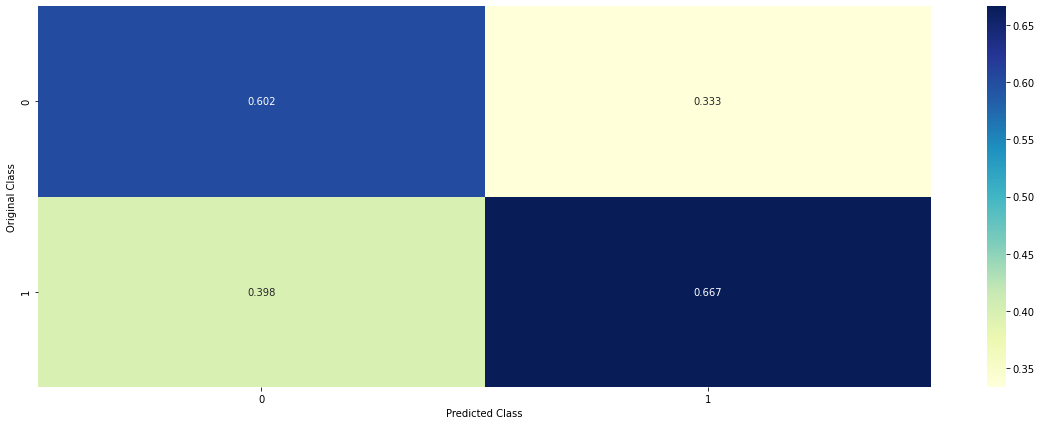

-------------------- Recall matrix (Row sum=1) --------------------


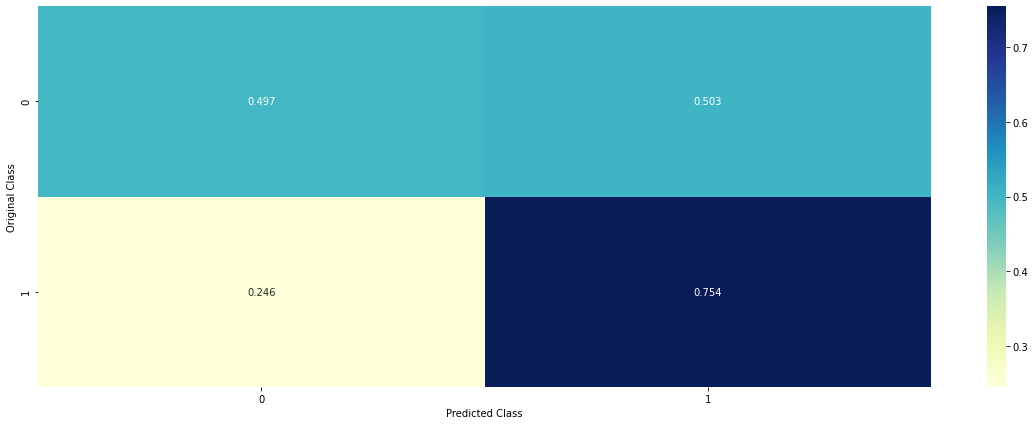

In [47]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBClassifier(learning_rate=i)
    k_fold_score = kfold(5,model,train_features,y_train)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBClassifier(learning_rate=best_n,class_weight='balanced')
model.fit(train_features,y_train)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_train,model.predict(train_features),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

In [ ]:
###############################################################################################################################

### Random Oversampling

In [76]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [81]:
om = RandomOverSampler(random_state=10) 
x_res , y_res = om.fit_resample(train_features,y_train)

In [82]:
print("class distribution BEFORE SMOTE in train data: \n",y_train.value_counts())
print("class distribution AFTER SMOTE in train data: \n",y_res.value_counts())

class distribution BEFORE SMOTE in train data: 
 1    48477
0    36351
Name: binary_target, dtype: int64
class distribution AFTER SMOTE in train data: 
 1    48477
0    48477
Name: binary_target, dtype: int64


In [83]:
def kfold_sampling(k,model):
    """This function will do stratified k-fold cross_validation"""
    kf = StratifiedKFold(n_splits=k)
    
    cv_f1_score = []
    for tr_ind,cv_ind in kf.split(x_res,y_res):
            
        x_tr,x_cv,y_tr,y_cv = x_res[tr_ind],x_res[cv_ind],y_res[tr_ind],y_res[cv_ind]
        
        model.fit(x_tr,y_tr)
        pred_cv = model.predict(x_cv)    
        cv_f1_score.append((f1_score(y_cv,pred_cv,average="macro",labels=[0,1])))
    
    return np.mean(cv_f1_score)   
            

### Logistic Regression

Macro F1 score at C=1e-05 is 0.6033744080722429 
Macro F1 score at C=0.0001 is 0.6057066305036551 
Macro F1 score at C=0.001 is 0.607843470845089 
Macro F1 score at C=0.01 is 0.6088772967935077 
Macro F1 score at C=0.1 is 0.608947832422056 
Macro F1 score at C=1 is 0.6092459113900259 
Macro F1 score at C=10 is 0.6093729133527036 
**************************************************


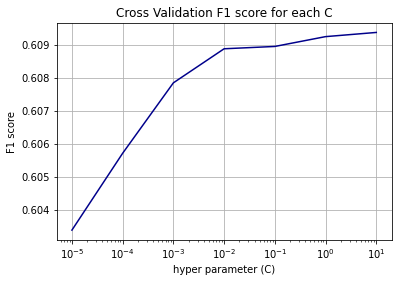

**************************************************
Train F1 score at 10 is :0.6097127688974593
**************************************************
test F1 score at 10 is :0.6048836027921374
-------------------- Confusion matrix --------------------


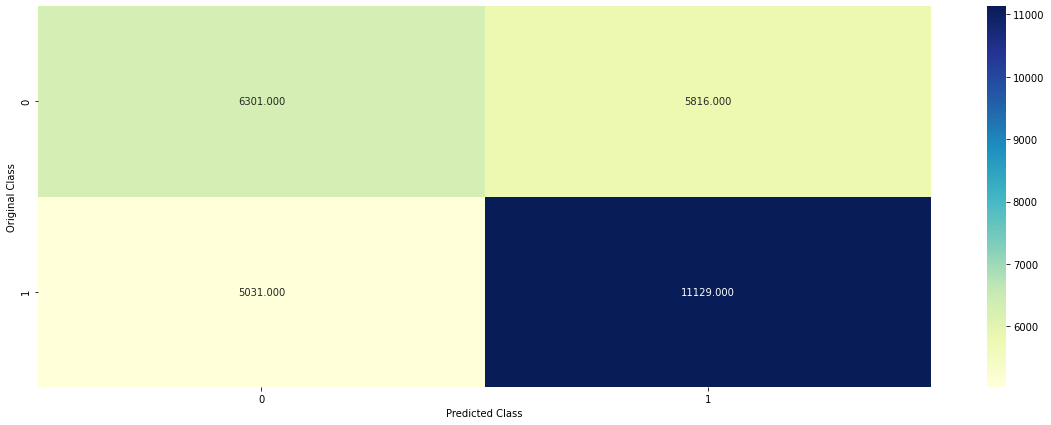

-------------------- Precision matrix (Columm Sum=1) --------------------


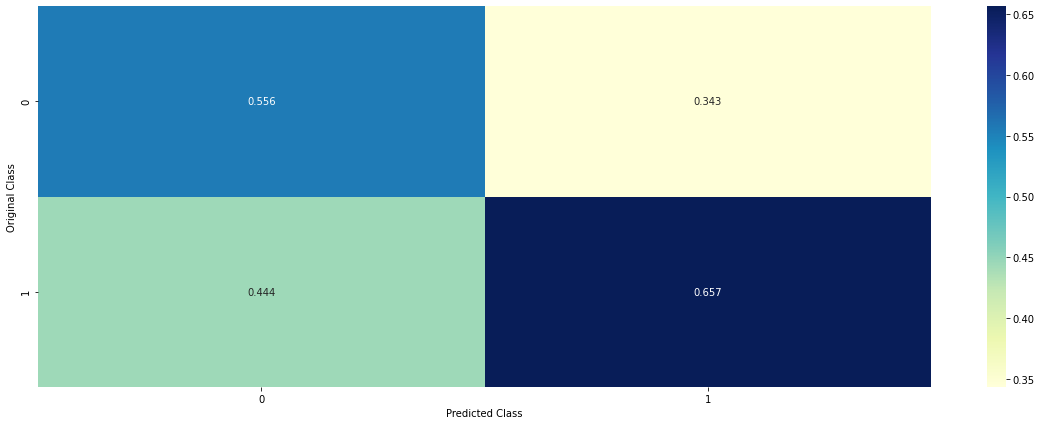

-------------------- Recall matrix (Row sum=1) --------------------


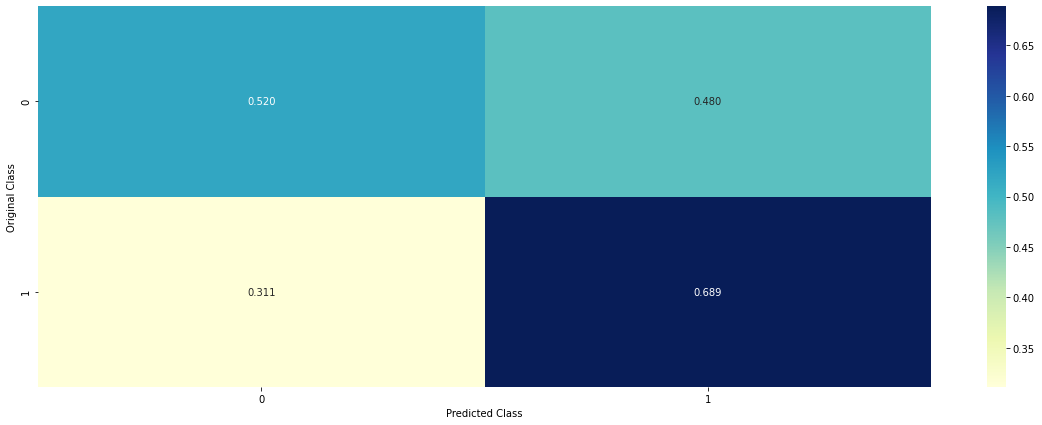

In [84]:
C=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in C:
    model = None
    model = LogisticRegression(C=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at C={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(C,f1_scores,color="darkblue")
plt.xscale("log")
plt.grid()
plt.title("Cross Validation F1 score for each C")
plt.xlabel("hyper parameter (C)")
plt.ylabel("F1 score")
plt.show()

best_param = C[np.argmax(f1_scores)]

model = None
model = LogisticRegression(C=i)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### Decision Tree

Macro F1 score at n=2 is 0.5687452947353915 
Macro F1 score at n=5 is 0.6054658458262236 
Macro F1 score at n=6 is 0.6110227785335637 
Macro F1 score at n=8 is 0.6102927652287299 
Macro F1 score at n=10 is 0.6134198051688231 
Macro F1 score at n=12 is 0.6261146022080801 
Macro F1 score at n=15 is 0.6393117178702605 
**************************************************


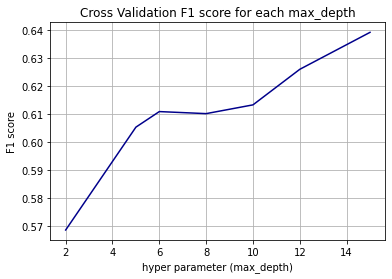

**************************************************
Train F1 score at 15 is :0.7207902073616186
**************************************************
test F1 score at 15 is :0.6245482973145802
-------------------- Confusion matrix --------------------


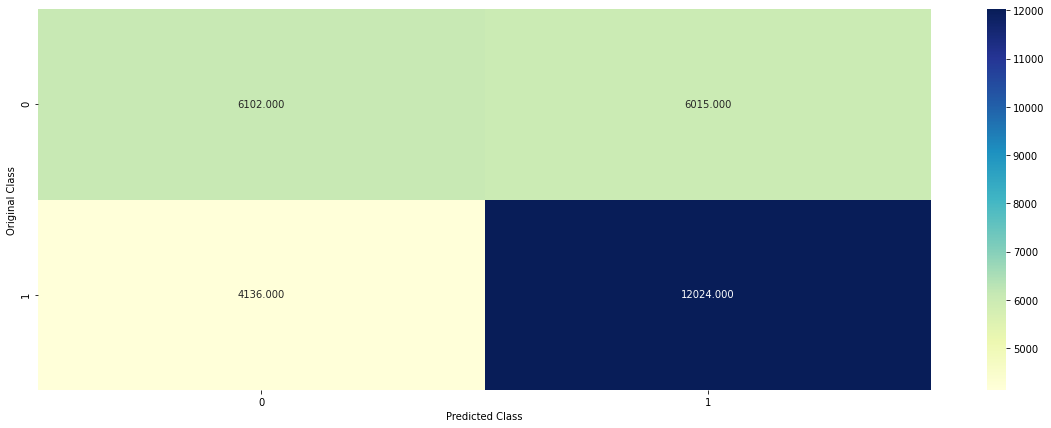

-------------------- Precision matrix (Columm Sum=1) --------------------


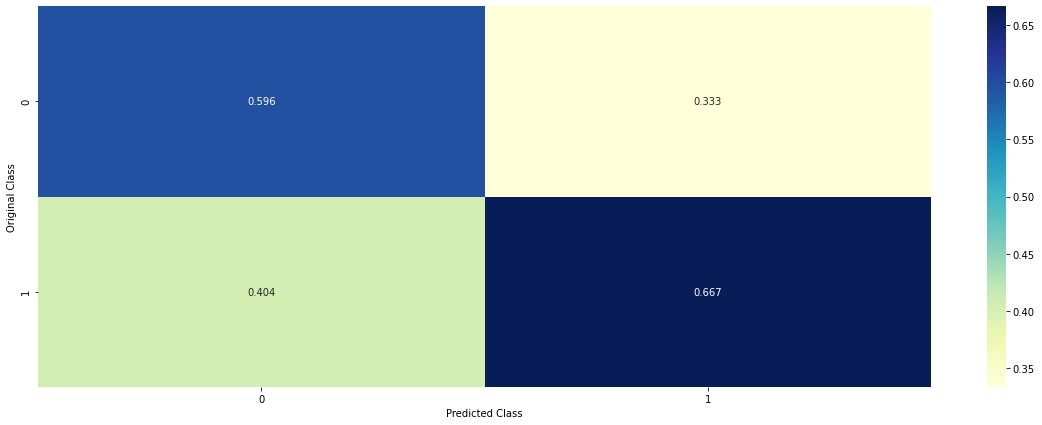

-------------------- Recall matrix (Row sum=1) --------------------


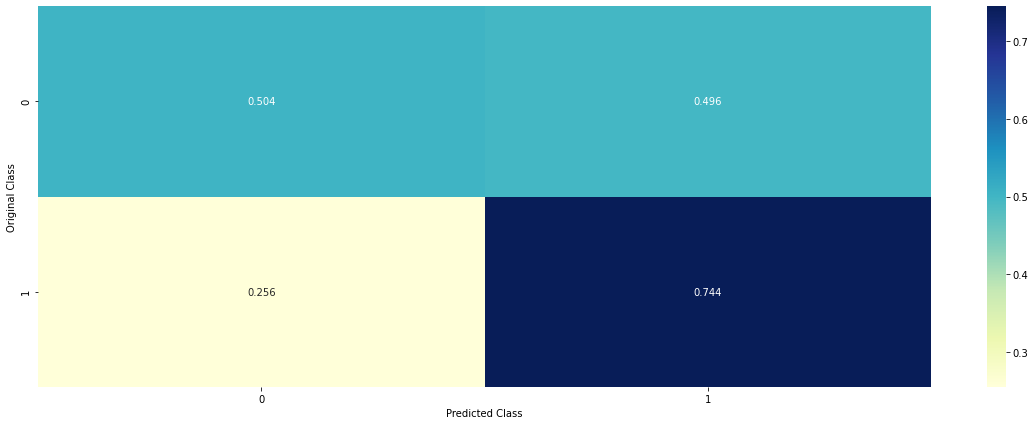

In [55]:
max_depth=[2,5,6,8,10,12,15]

f1_scores = []
for i in max_depth:
    model = None
    model = DecisionTreeClassifier(max_depth=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(max_depth,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each max_depth")
plt.xlabel("hyper parameter (max_depth)")
plt.ylabel("F1 score")
plt.show()

best_param = max_depth[np.argmax(f1_scores)]

model = None
model = DecisionTreeClassifier(max_depth=best_param)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### Random forest

Macro F1 score at n=10 is 0.7099947608852396 
Macro F1 score at n=20 is 0.7389806301833941 
Macro F1 score at n=50 is 0.7639701967521602 
Macro F1 score at n=100 is 0.773319784614461 
Macro F1 score at n=150 is 0.77706779737456 
Macro F1 score at n=200 is 0.7794823499054206 
Macro F1 score at n=300 is 0.7798772339054366 
Macro F1 score at n=500 is 0.7816289752838644 
**************************************************


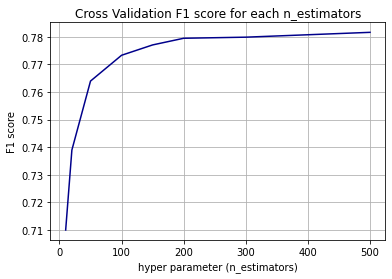

**************************************************
Train F1 score at 500 is :0.9990614105433693
**************************************************
test F1 score at 500 is :0.6866765711400296
-------------------- Confusion matrix --------------------


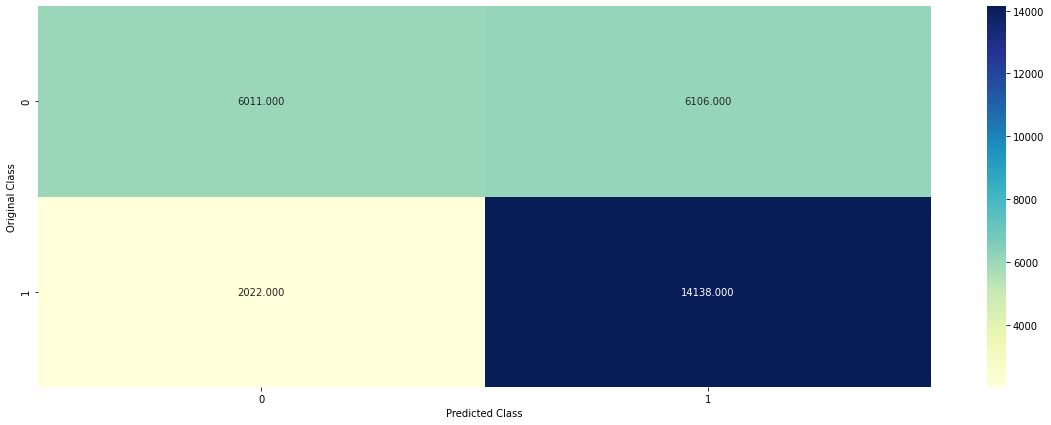

-------------------- Precision matrix (Columm Sum=1) --------------------


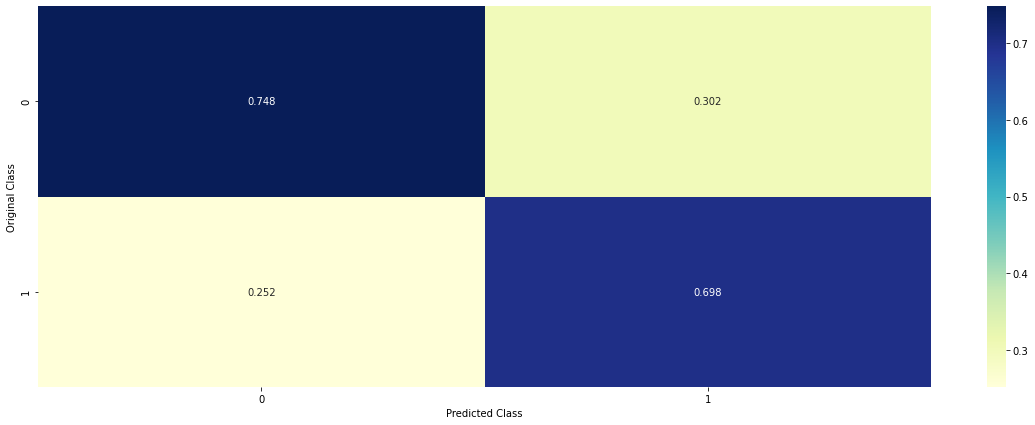

-------------------- Recall matrix (Row sum=1) --------------------


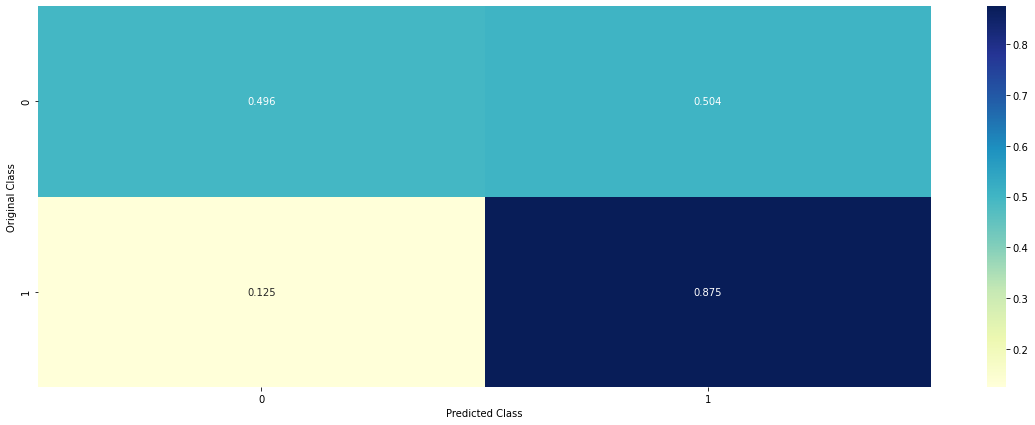

In [56]:
n_estimators=[10,20,50,100,150,200,300,500]


f1_scores = []
for i in n_estimators:
    model = None
    model = RandomForestClassifier(n_estimators=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at n={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(n_estimators,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each n_estimators")
plt.xlabel("hyper parameter (n_estimators)")
plt.ylabel("F1 score")
plt.show()

best_param = n_estimators[np.argmax(f1_scores)]

model = None
model = RandomForestClassifier(n_estimators=best_param)
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is :{}".format(best_param, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{}".format(best_param, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix
predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### XGBRF

[18:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

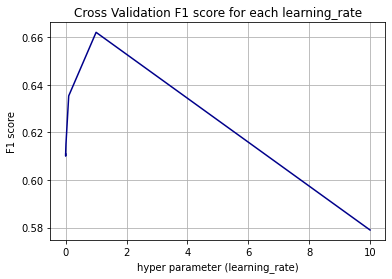

[18:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**************************************************
Train F1 score at 1 is  :0.8064228952634799 
**************************************************
test F1 score at 1 is :0.6240521502730119 
-------------------- Confusion matrix --------------------


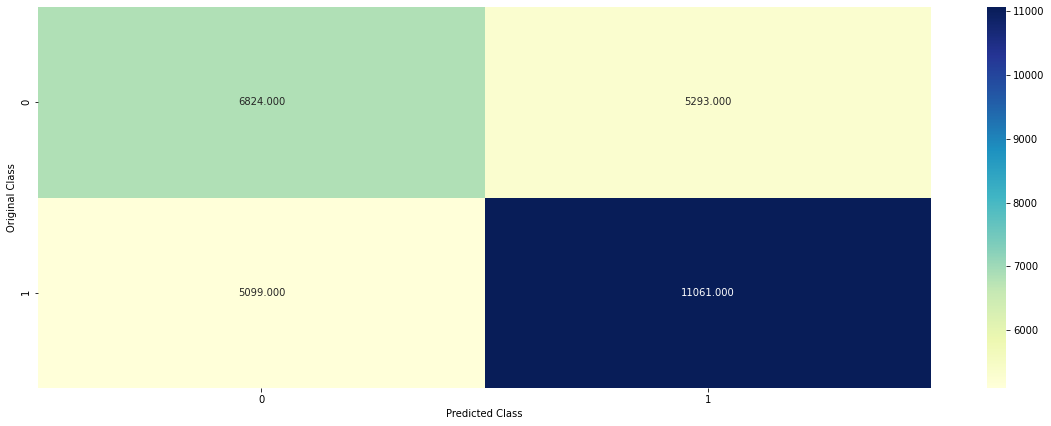

-------------------- Precision matrix (Columm Sum=1) --------------------


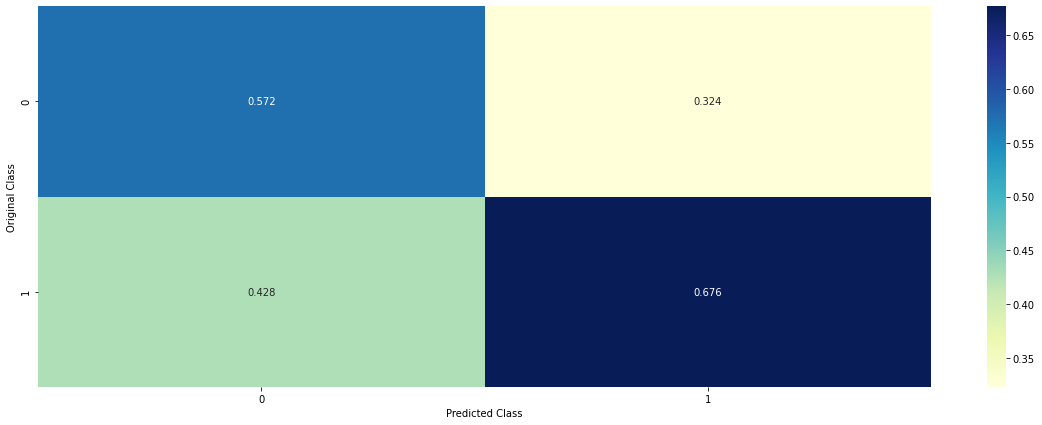

-------------------- Recall matrix (Row sum=1) --------------------


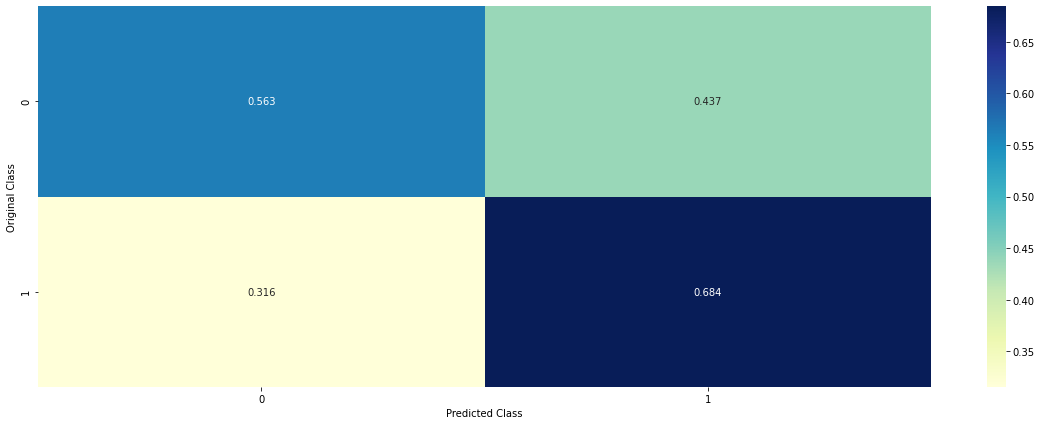

In [85]:
learning_rate=[0.00001,0.0001,0.001,0.01,0.1,1,10]

f1_scores = []
for i in learning_rate:
    model = None
    model = xgb.XGBClassifier(learning_rate=i)
    k_fold_score = kfold_sampling(5,model)
    f1_scores.append(k_fold_score)
    print("Macro F1 score at learning_rate={} is {} ".format(i,k_fold_score))

    
    
print("*"*50)    
plt.plot(learning_rate,f1_scores,color="darkblue")

plt.grid()
plt.title("Cross Validation F1 score for each learning_rate")
plt.xlabel("hyper parameter (learning_rate)")
plt.ylabel("F1 score")
plt.show()

best_n = learning_rate[np.argmax(f1_scores)]


model = None
model = xgb.XGBClassifier(learning_rate=best_n,class_weight='balanced')
model.fit(x_res,y_res)


print("*"*50)
print("Train F1 score at {} is  :{} ".format(best_n, f1_score(y_res,model.predict(x_res),labels=model.classes_,average="macro")))
print("*"*50)
print("test F1 score at {} is :{} ".format(best_n, f1_score(y_test,model.predict(test_features),labels=model.classes_,average="macro")))


#plotting confusion matrix

predicted = model.predict(test_features)
plot_confusion_matrix(y_test,predicted)

### LGBM

In [58]:
param_grid = { 
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [5,10,50,100,200,250]}

clf = lgb.LGBMClassifier(n_jobs=-1,boosting_type="goss")
random_search = RandomizedSearchCV(clf, param_grid, n_iter=30,n_jobs=-1,scoring="f1_macro",
                                   verbose=1, cv=5, refit=False, random_state=42)
random_search.fit(x_res, y_res)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(boosting_type='goss'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'n_estimators': [5, 10, 50, 100, 200,
                                                         250]},
                   random_state=42, refit=False, scoring='f1_macro', verbose=1)

In [60]:
params = random_search.best_params_
params

{'n_estimators': 250, 'learning_rate': 0.1}

Train F1 score is  :0.7112466091857768 
**************************************************
test F1 score is :0.6320387076110848 
-------------------- Confusion matrix --------------------


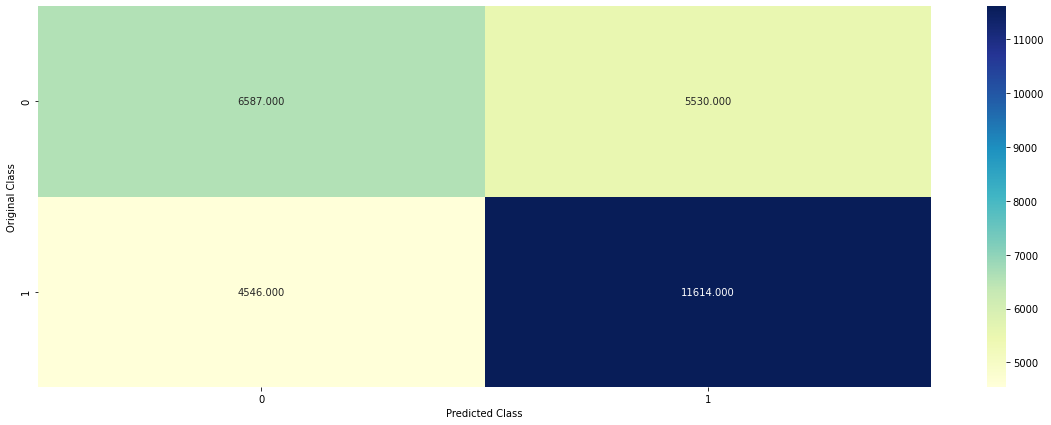

-------------------- Precision matrix (Columm Sum=1) --------------------


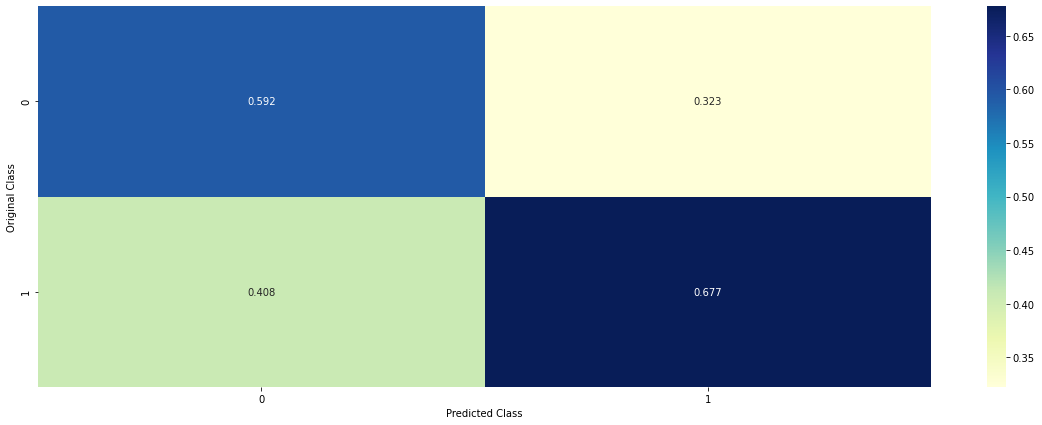

-------------------- Recall matrix (Row sum=1) --------------------


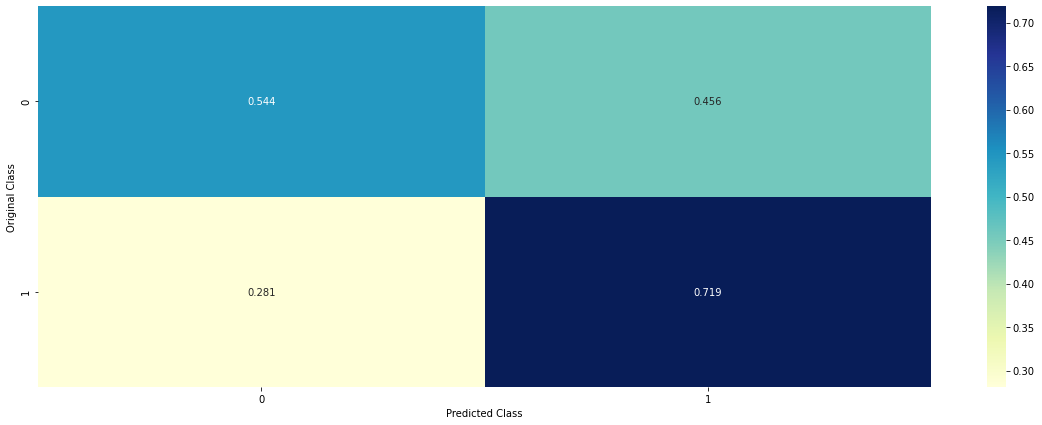

In [62]:
clf = lgb.LGBMClassifier(n_estimators= params["n_estimators"],
                         boosting_type="goss",
                        learning_rate= params["learning_rate"], n_jobs=-1)
clf.fit(x_res,y_res)

pred_test = clf.predict(test_features)
pred_train = clf.predict(x_res)

print("Train F1 score is  :{} ".format(f1_score(y_res,pred_train,labels=[0,1],average="macro")))
print("*"*50)
print("test F1 score is :{} ".format(f1_score(y_test,pred_test,labels=[0,1],average="macro")))

plot_confusion_matrix(y_test,pred_test)

### Summary table

|Model|Train macro F1 score|Test macro F1 score|
|----|----|----|
|Logistic regression|0.614 |0.608 |
|SVM|0.364|0.364|
|KNN|0.816|0.611|
|Decision Tree|0.725 |0.621 |
|Random Forest|0.99 |0.68 |
|LGBM|0.925 |0.644 | 
|XGBoost|0.807 |0.628 |

<b> With feature selection</b>

|Model|Train macro F1 score|Test macro F1 score|
|----|----|----|
|Logistic regression|0.613 |0.608 |
|Random Forest| 0.998|0.683 |
|LGBM|0.959 |0.677 | 
|XGBoost|0.804 |0.626 |

<b> With random oversampling</b>

|Model|Train macro F1 score|Test macro F1 score|
|----|----|----|
|Logistic regression|0.609 |0.605 |
|Decision Tree|0.72 |0.624 |
|Random Forest|0.99 |0.686 |
|LGBM|0.711 |0.63 | 
|XGBoost| 0.806|0.624 |